## Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/project/kitti_data

/content/drive/My Drive/project/kitti_data


In [0]:
%%capture
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
import cv2
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, MaxPool2D,  Conv2D, Dropout, concatenate, Reshape, Lambda, AveragePooling2D
from keras.initializers import TruncatedNormal
from keras.regularizers import l2
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import os
import gc
import time
from tqdm import tqdm_notebook as tqdm

## Parameter

In [0]:
# -------------------Image Parameter Part-------------------------
IMAGE_WIDTH = 1248
IMAGE_HEIGHT = 384
# -------------------Classification Parameter Part-------------------------
CLASS_TO_COLOR = {"car": (0, 191, 255),
                  "cyclist": (255, 0, 191),
                  "pedestrian": (255, 191, 0)}
CLASS_NAMES = ['cyclist', 'pedestrian', 'car']
# Number of categories
NUM_CLASSES = len(CLASS_NAMES)
# Convert to a class index dictionary
CLASS_TO_IDX = dict(zip(CLASS_NAMES, range(NUM_CLASSES)))
# Colour of class in Visualization
FONT = cv2.FONT_HERSHEY_SIMPLEX
# -------------------Train Part-------------------------
BATCH_SIZE = 4
# -------------------Prediction Threshold Part-------------------------
SHOW_RESULT_THRESH = 0.59
# -------------------Anchor Box Parameter Part-------------------------
def set_grid_anchors():
    Height, Width, Num = NUM_VERTICAL_ANCHORS, NUM_HORIZ_ANCHORS, ANCHOR_PER_GRID
    anchor_shapes = np.reshape([ANCHOR_RATIO] * Height * Width, (Height, Width, Num, 2))
    center_x = np.array([np.arange(1, Width+1)*float(IMAGE_WIDTH)/(Width+1)]*Height*Num)
    center_x = np.reshape(np.transpose(np.reshape(center_x, (Num, Height, Width)),(1, 2, 0)),(Height, Width, Num, 1))
    center_y = np.array([np.arange(1, Height+1)*float(IMAGE_HEIGHT)/(Height+1)]*Width*Num)
    center_y = np.reshape(np.transpose(np.reshape(center_y, (Num, Width, Height)),(2, 1, 0)),(Height, Width, Num, 1))
    anchors = np.reshape(np.concatenate((center_x, center_y, anchor_shapes), axis=3), (-1, 4))
    return anchors
# Default anchor box parameter
ANCHOR_RATIO = np.array([[36., 37.], [366., 174.], [115., 59.], 
                        [162., 87.], [38., 90.], [258., 173.], 
                        [224., 108.], [78., 170.], [72., 43.]])
ANCHOR_PER_GRID = len(ANCHOR_RATIO)
NUM_VERTICAL_ANCHORS = 24
NUM_HORIZ_ANCHORS = 78
# Get the anchors for the grid
ANCHOR_BOX = set_grid_anchors()
ANCHORS = len(ANCHOR_BOX)

## Helper functions

In [0]:
def batch_iou(boxes, box):
    """
    Compute the Intersection-Over-Union of a batch of boxes with another box.
    :param boxes: 2D array of [cx, cy, width, height].
    :param box: a single array of [cx, cy, width, height]
    :returns: array of ious
    """
    int_xlr = np.maximum(
        np.minimum(boxes[:,0]+0.5*boxes[:,2], box[0]+0.5*box[2]) - \
        np.maximum(boxes[:,0]-0.5*boxes[:,2], box[0]-0.5*box[2]), 0)
    int_ytb = np.maximum(
        np.minimum(boxes[:,1]+0.5*boxes[:,3], box[1]+0.5*box[3]) - \
        np.maximum(boxes[:,1]-0.5*boxes[:,3], box[1]-0.5*box[3]), 0)
    intersection = int_xlr * int_ytb
    area1, area2 = boxes[:,2]*boxes[:,3], box[2]*box[3]
    union =  area1 + area2 - intersection
    return intersection/union

def tensor_iou(box1, box2, input_mask):
    """Computes pairwise IOU of two lists of boxes
    :param box1: array of [xmin, ymin, xmax, ymax] format
    :param box2: array of [xmin, ymin, xmax, ymax] format
    :param input_mask: indicating which boxes to compute
    :returns: iou of the two boxes
    """
    xl = K.maximum(box1[0], box2[0])
    xr = K.minimum(box1[2], box2[2])
    yb = K.maximum(box1[1], box2[1])
    yt = K.minimum(box1[3], box2[3])
    intersection = K.maximum(0.0, xr - xl) * K.maximum(0.0, yt - yb)
    w1 = box1[2] - box1[0]
    h1 = box1[3] - box1[1]
    w2 = box2[2] - box2[0]
    h2 = box2[3] - box2[1]
    area1, area2 = w1 * h1, w2 * h2
    union = area1 + area2 - intersection
    return intersection / (union + 1e-7) * K.reshape(input_mask, [BATCH_SIZE, ANCHORS]) # To prevent zero division

def non_maximum_suppression(boxes, probs, thresh):
    """
    Non-Maximum supression.
    :param boxes: array of [cx, cy, w, h] format
    :param probs: array of probabilities
    :param thresh: threshold to decide overlapping
    :returns: array of True or False.
    """
    order_desc = probs.argsort()[::-1]
    res = [True]*len(order_desc)
    for i in range(len(order_desc)-1):
      overlaps = batch_iou(boxes[order_desc[i+1:]], boxes[order_desc[i]])
      for j, overlap in enumerate(overlaps):
        if overlap > thresh:
          res[order_desc[j+i+1]] = False
    return res

def sparse_to_dense(sp_indices, output_shape, values, default_value=0):
    """
    Build a dense matrix from sparse representations.
    """
    assert len(sp_indices) == len(values), \
        'Length of sp_indices is not equal to length of values'
    array = np.ones(output_shape) * default_value
    for idx, value in zip(sp_indices, values):
      array[tuple(idx)] = value
    return array

def convert_bbox_diagonal(bbox):
    """
    Convert a bounding box of form [cx, cy, w, h] to the form of 
    [xmin, ymin, xmax, ymax]. 
    """
    cx, cy, w, h = bbox
    res_box = [[]]*4
    res_box[0] = cx - w/2
    res_box[1] = cy - h/2
    res_box[2] = cx + w/2
    res_box[3] = cy + h/2
    return res_box

def convert_bbox_center(bbox):
    """
    Convert a bbox of form [xmin, ymin, xmax, ymax] to the form of 
    [cx, cy, w, h]. 
    """
    xmin, ymin, xmax, ymax = bbox
    res_box = [[]]*4
    width = xmax - xmin + 1.0
    height = ymax - ymin + 1.0
    res_box[0]  = xmin + 0.5*width
    res_box[1]  = ymin + 0.5*height
    res_box[2]  = width
    res_box[3]  = height
    return res_box

def convert_deltas_to_bboxes(pred_box_delta):
    """
    Converts prediction deltas to bounding boxes
    :param pred_box_delta: tensor of deltas
    :returns: tensor of bounding boxes
    """

    def exp_helper_tensor(w, thresh=1.0):
        """ Safe exponential function. """
        slope = np.exp(thresh)
        lin_bool = w > thresh
        lin_region = K.cast(lin_bool, dtype='float32')
        lin_out = slope*(w - thresh + 1.)
        exp_out = K.exp(K.switch(lin_bool, K.zeros_like(w), w))
        out = lin_region*lin_out + (1.-lin_region)*exp_out
        return out

    # Get the coordinates and sizes of the anchor boxes and deltas 
    anchor_x = ANCHOR_BOX[:, 0]
    anchor_y = ANCHOR_BOX[:, 1]
    anchor_w = ANCHOR_BOX[:, 2]
    anchor_h = ANCHOR_BOX[:, 3]
    delta_x = pred_box_delta[:, :, 0]
    delta_y = pred_box_delta[:, :, 1]
    delta_w = pred_box_delta[:, :, 2]
    delta_h = pred_box_delta[:, :, 3]
    # Get the anchor box values
    box_cx = K.identity(anchor_x + delta_x * anchor_w)
    box_cy = K.identity(anchor_y + delta_y * anchor_h)
    box_w = K.identity(anchor_w * exp_helper_tensor(delta_w))
    box_h = K.identity(anchor_h * exp_helper_tensor(delta_h))
    # Tranform into a [xmin, ymin, xmax, ymax] format
    xmins, ymins, xmaxs, ymaxs = convert_bbox_diagonal([box_cx, box_cy, box_w, box_h])
    xmins = K.minimum(K.maximum(0.0, xmins), IMAGE_WIDTH - 1.0)
    ymins = K.minimum(K.maximum(0.0, ymins), IMAGE_HEIGHT - 1.0)
    xmaxs = K.maximum(K.minimum(IMAGE_WIDTH - 1.0, xmaxs), 0.0)
    ymaxs = K.maximum(K.minimum(IMAGE_HEIGHT - 1.0, ymaxs), 0.0)
    det_boxes = K.permute_dimensions(K.stack(convert_bbox_center([xmins, ymins, xmaxs, ymaxs])), (1, 2, 0))
    return (det_boxes)

def split_predictions(y_pred):
    """
    :param y_pred: network prediction output
    :return: unpadded and sliced predictions
    """
    # Compute non padded prediction part
    n_outputs = NUM_CLASSES + 1 + 4
    y_pred = y_pred[:, :, 0:n_outputs]
    y_pred = K.reshape(y_pred, (BATCH_SIZE, NUM_VERTICAL_ANCHORS, NUM_HORIZ_ANCHORS, -1))
    # Get the index, need to compute the number of total class probabilities(n classes for each anchor)
    idx_class_probs = ANCHOR_PER_GRID * NUM_CLASSES
    # Get class pred scores
    class_probs = K.reshape(y_pred[:, :, :, :idx_class_probs], [-1, NUM_CLASSES])
    class_probs = K.softmax(class_probs)
    class_probs = K.reshape(class_probs, [BATCH_SIZE, ANCHORS, NUM_CLASSES])
    # Get the index, neet to compute the number of confidence scores(1 score for each anchor)
    idx_confidence_scores = ANCHOR_PER_GRID * 1 + idx_class_probs
    # Get the confidence scores (sigmoid for probabilities)
    conf_score = K.reshape(y_pred[:, :, :, idx_class_probs:idx_confidence_scores], [BATCH_SIZE, ANCHORS])
    conf_score = K.sigmoid(conf_score)
    # Get the bounding box deltas
    box_delta = K.reshape(y_pred[:, :, :, idx_confidence_scores:], [BATCH_SIZE, ANCHORS, 4])
    return [class_probs, conf_score, box_delta]

def convert_deltas_to_bboxes_np(pred_box_delta):
    """
    Converts prediction deltas to bounding boxes
    :param pred_box_delta: tensor of deltas
    :returns: tensor of bounding boxes
    """

    def exp_helper_np(w, thresh=1.0):
        """ Safe exponential function for numpy. """
        slope = np.exp(thresh)
        lin_bool = w > thresh
        lin_region = lin_bool.astype(float)
        lin_out = slope*(w - thresh + 1.)
        exp_out = np.exp(np.where(lin_bool, np.zeros_like(w), w))
        out = lin_region*lin_out + (1.-lin_region)*exp_out
        return out

    # Get the coordinates and sizes of the anchor boxes and deltas
    anchor_x = ANCHOR_BOX[:, 0]
    anchor_y = ANCHOR_BOX[:, 1]
    anchor_w = ANCHOR_BOX[:, 2]
    anchor_h = ANCHOR_BOX[:, 3]
    delta_x = pred_box_delta[:, :, 0]
    delta_y = pred_box_delta[:, :, 1]
    delta_w = pred_box_delta[:, :, 2]
    delta_h = pred_box_delta[:, :, 3]
    # Get the anchor box values
    box_cx = anchor_x + delta_x * anchor_w
    box_cy = anchor_y + delta_y * anchor_h
    box_w = anchor_w * exp_helper_np(delta_w)
    box_h = anchor_h * exp_helper_np(delta_h)
    # Tranform into a [xmin, ymin, xmax, ymax] format
    xmins, ymins, xmaxs, ymaxs = convert_bbox_diagonal([box_cx, box_cy, box_w, box_h])
    xmins = np.minimum(np.maximum(0.0, xmins), IMAGE_WIDTH - 1.0)
    ymins = np.minimum(np.maximum(0.0, ymins), IMAGE_HEIGHT - 1.0)
    xmaxs = np.maximum(np.minimum(IMAGE_WIDTH - 1.0, xmaxs), 0.0)
    ymaxs = np.maximum(np.minimum(IMAGE_HEIGHT - 1.0, ymaxs), 0.0)
    det_boxes = np.transpose(np.stack(convert_bbox_center([xmins, ymins, xmaxs, ymaxs])), (1, 2, 0))
    return (det_boxes)

def split_predictions_np(y_pred):
    """
    :param y_pred: network prediction output
    :return: unpadded and sliced predictions
    """
    # Compute non padded prediction part
    n_outputs = NUM_CLASSES + 1 + 4
    y_pred = y_pred[:, :, 0:n_outputs]
    y_pred = np.reshape(y_pred, (BATCH_SIZE, NUM_VERTICAL_ANCHORS, NUM_HORIZ_ANCHORS, -1))
    # Get the index, need to compute the number of total class probabilities(n classes for each anchor)
    idx_class_probs = ANCHOR_PER_GRID * NUM_CLASSES
    # Get class pred scores
    class_probs = np.reshape(y_pred[:, :, :, :idx_class_probs], [-1, NUM_CLASSES])
    class_probs = softmax(class_probs)
    class_probs = np.reshape(class_probs, [BATCH_SIZE, ANCHORS, NUM_CLASSES])
    # Get the index, neet to compute the number of confidence scores(1 score for each anchor)
    idx_confidence_scores = ANCHOR_PER_GRID * 1 + idx_class_probs
    # Get the confidence scores (sigmoid for probabilities)
    conf_score = np.reshape(y_pred[:, :, :, idx_class_probs:idx_confidence_scores], [BATCH_SIZE, ANCHORS])
    conf_score = sigmoid(conf_score)
    # Get the bounding box deltas
    box_delta = np.reshape(y_pred[:, :, :, idx_confidence_scores:], [BATCH_SIZE, ANCHORS, 4])
    return [class_probs, conf_score, box_delta]

def softmax(x, axis=-1):
    """ Compute softmax values. """
    e_x = np.exp(x - np.max(x))
    return e_x / np.expand_dims(np.sum(e_x,axis=axis), axis=axis)

def sigmoid(x):
    """ Sigmoid function """
    return 1 / (1 + np.exp(-x))

def get_annotation(ytrue_file):
    """ Get annotations from file. """
    with open(ytrue_file, 'r') as f:
        lines = f.readlines()
    f.close()
    annotations = []
    # Get annotation bounding box for each line
    for line in lines:
        item = line.strip().split(' ')
        # Only get the class we care
        try:
            cls = CLASS_TO_IDX[item[0].lower().strip()]
            # Get bounding box
            xmin = float(item[4])
            ymin = float(item[5])
            xmax = float(item[6])
            ymax = float(item[7])
            # Transform to [cx, cy, w, h] format
            cx, cy, w, h = convert_bbox_center([xmin, ymin, xmax, ymax])
            annotations.append([cx, cy, w, h, cls])
        except:
            continue
    return annotations

## Data generators

### Data Generator

In [0]:
class DataGen(keras.utils.Sequence):
    def __init__(self, img_names, ytrue_names, batch_size=4, img_height=384, img_width=1248):
        self.img_names = img_names
        self.ytrue_names = ytrue_names
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.on_epoch_end()
        
    def __load__(self, img_name, ytrue_name):
        aidx_per_image, delta_per_image = [], []
        aidx_set = set()
        # Read image
        img = cv2.imread(img_name).astype(np.float32, copy=False)
        # Store original width and height
        orig_h, orig_w, _ = [float(v) for v in img.shape]
        # Rescale image
        img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        img = (img - np.mean(img))/ np.std(img)
        # Load annotations(format:[[cx, cy, w, h, cls],...,[cx, cy, w, h, cls]])
        annotations = get_annotation(ytrue_name)
        # Get all the classes for that image 
        labels_per_image = [a[4] for a in annotations]
        # Get all the corresponding bounding boxes  
        bboxes_per_image = np.array([a[0:4]for a in annotations])
        # scale annotation
        x_scale = IMAGE_WIDTH / orig_w
        bboxes_per_image[:, 0::2] = bboxes_per_image[:, 0::2] * x_scale # scale parameter(x, w)
        y_scale = IMAGE_HEIGHT / orig_h
        bboxes_per_image[:, 1::2] = bboxes_per_image[:, 1::2] * y_scale # scale parameter(y, h)
        # Go through all the bounding boxes for that image
        for i in range(len(bboxes_per_image)):
            overlaps = batch_iou(ANCHOR_BOX, bboxes_per_image[i])
            # Set anchor box index to the number of all the anchor box
            aidx = ANCHORS
            # Choose the one with the largest overlaps
            for overlap_idx in np.argsort(overlaps)[::-1]:
                if overlaps[overlap_idx] <= 0:
                    break
                if overlap_idx not in aidx_set:
                    aidx_set.add(overlap_idx)
                    aidx = overlap_idx
                    break
            # Case when the largest available overlap is 0
            if aidx == ANCHORS:
                # Choose the one that has the smallest distance
                dist = np.sum(np.square(bboxes_per_image[i] - ANCHOR_BOX), axis=1)
                for dist_idx in np.argsort(dist):
                    if dist_idx not in aidx_set:
                        aidx_set.add(dist_idx)
                        aidx = dist_idx
                        break
            # Get deltas for loss regression
            box_cx, box_cy, box_w, box_h = bboxes_per_image[i]
            delta = [0] * 4
            delta[0] = (box_cx - ANCHOR_BOX[aidx][0]) / ANCHOR_BOX[aidx][2]
            delta[1] = (box_cy - ANCHOR_BOX[aidx][1]) / ANCHOR_BOX[aidx][3]
            delta[2] = np.log(box_w / ANCHOR_BOX[aidx][2])
            delta[3] = np.log(box_h / ANCHOR_BOX[aidx][3])
            aidx_per_image.append(aidx)
            delta_per_image.append(delta)

        return img, labels_per_image, bboxes_per_image, delta_per_image, aidx_per_image
    
    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.img_names):
            self.batch_size = len(self.img_names) - index * self.batch_size 
        
        img_names_batch = self.img_names[index * self.batch_size : (index + 1) * self.batch_size]
        ytrue_names_batch = self.ytrue_names[index * self.batch_size : (index + 1) * self.batch_size]

        imgs = []
        labels = []
        bboxes = []
        deltas = []
        aidxs = []
        
        for img_name, ytrue_name in zip(img_names_batch, ytrue_names_batch):
            _img, _labels, _bboxes, _deltas, _aidxs = self.__load__(img_name, ytrue_name)
            imgs.append(_img)
            labels.append(_labels)
            bboxes.append(_bboxes)
            deltas.append(_deltas)
            aidxs.append(_aidxs)

        # we need to transform this batch annotations into a form we can feed into the model
        label_indices, bbox_indices, delta_values, input_mask_indices, box_values = [], [], [], [], []
        aidx_set = set()

        for i in range(len(labels)):
            for j in range(len(labels[i])):
                if (i, aidxs[i][j]) not in aidx_set:
                    aidx_set.add((i, aidxs[i][j]))
                    input_mask_indices.append([i, aidxs[i][j]])
                    bbox_indices.extend([[i, aidxs[i][j], k] for k in range(4)])
                    box_values.extend(bboxes[i][j])
                    delta_values.extend(deltas[i][j])
                    label_indices.append([i, aidxs[i][j], labels[i][j]])

        # transform them into matrices
        input_masks = sparse_to_dense(input_mask_indices, [BATCH_SIZE, ANCHORS],[1.0] * len(input_mask_indices))
        input_masks = np.reshape(input_masks, [BATCH_SIZE, ANCHORS, 1])

        boxes =  sparse_to_dense(bbox_indices, [BATCH_SIZE, ANCHORS, 4], box_values)

        box_deltas = sparse_to_dense(bbox_indices, [BATCH_SIZE, ANCHORS, 4], delta_values)
        
        labels = sparse_to_dense(label_indices, [BATCH_SIZE, ANCHORS, NUM_CLASSES], [1.0] * len(label_indices))

        Y = np.concatenate((input_masks, boxes, box_deltas, labels), axis=-1).astype(np.float32)
        imgs = np.array(imgs)  
        return imgs, Y
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.img_names)/float(self.batch_size)))

### Data generator (with original image)

In [0]:
class DataGenOrigin(keras.utils.Sequence):
    def __init__(self, img_names, ytrue_names, batch_size, img_height=384, img_width=1248):
        self.img_names = img_names
        self.ytrue_names = ytrue_names
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.on_epoch_end()
        
    def __load__(self, img_name, ytrue_name):
        aidx_per_image, delta_per_image = [], []
        aidx_set = set()
        # Read image
        img = cv2.imread(img_name).astype(np.float32, copy=False)
        # Store original width and height
        orig_h, orig_w, _ = [float(v) for v in img.shape]
        # Rescale image
        img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        orig_img = img
        img = (img - np.mean(img))/ np.std(img)
        # Load annotations(format:[[cx, cy, w, h, cls],...,[cx, cy, w, h, cls]])
        annotations = get_annotation(ytrue_name)
        # Get all the classes for that image 
        labels_per_image = [a[4] for a in annotations]
        # Get all the corresponding bounding boxes  
        bboxes_per_image = np.array([a[0:4]for a in annotations])
        # scale annotation
        x_scale = IMAGE_WIDTH / orig_w
        bboxes_per_image[:, 0::2] = bboxes_per_image[:, 0::2] * x_scale # scale parameter(x, w)
        y_scale = IMAGE_HEIGHT / orig_h
        bboxes_per_image[:, 1::2] = bboxes_per_image[:, 1::2] * y_scale # scale parameter(y, h)
        # Go through all the bounding boxes for that image
        for i in range(len(bboxes_per_image)):
            overlaps = batch_iou(ANCHOR_BOX, bboxes_per_image[i])
            # Set anchor box index to the number of all the anchor box
            aidx = ANCHORS
            # Choose the one with the largest overlaps
            for overlap_idx in np.argsort(overlaps)[::-1]:
                if overlaps[overlap_idx] <= 0:
                    break
                if overlap_idx not in aidx_set:
                    aidx_set.add(overlap_idx)
                    aidx = overlap_idx
                    break
            # Case when the largest available overlap is 0
            if aidx == ANCHORS:
                # Choose the one that has the smallest distance
                dist = np.sum(np.square(bboxes_per_image[i] - ANCHOR_BOX), axis=1)
                for dist_idx in np.argsort(dist):
                    if dist_idx not in aidx_set:
                        aidx_set.add(dist_idx)
                        aidx = dist_idx
                        break
            #compute deltas for regression
            box_cx, box_cy, box_w, box_h = bboxes_per_image[i]
            delta = [0] * 4
            delta[0] = (box_cx - ANCHOR_BOX[aidx][0]) / ANCHOR_BOX[aidx][2]
            delta[1] = (box_cy - ANCHOR_BOX[aidx][1]) / ANCHOR_BOX[aidx][3]
            delta[2] = np.log(box_w / ANCHOR_BOX[aidx][2])
            delta[3] = np.log(box_h / ANCHOR_BOX[aidx][3])
            aidx_per_image.append(aidx)
            delta_per_image.append(delta)

        return img, orig_img, labels_per_image, bboxes_per_image, delta_per_image, aidx_per_image
    
    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.img_names):
            self.batch_size = len(self.img_names) - index * self.batch_size 
        
        img_names_batch = self.img_names[index * self.batch_size : (index + 1) * self.batch_size]
        ytrue_names_batch = self.ytrue_names[index * self.batch_size : (index + 1) * self.batch_size]

        imgs = []
        orig_imgs = []
        labels = []
        bboxes = []
        deltas = []
        aidxs = []
        
        for img_name, ytrue_name in zip(img_names_batch, ytrue_names_batch):
            _img, _orig_img, _labels, _bboxes, _deltas, _aidxs = self.__load__(img_name, ytrue_name)
            imgs.append(_img)
            orig_imgs.append(_orig_img)
            labels.append(_labels)
            bboxes.append(_bboxes)
            deltas.append(_deltas)
            aidxs.append(_aidxs)

        #we need to transform this batch annotations into a form we can feed into the model
        label_indices, bbox_indices, delta_values, input_mask_indices, box_values = [], [], [], [], []
        aidx_set = set()
        #iterate batch
        for i in range(len(labels)):
            #and annotations
            for j in range(len(labels[i])):
                if (i, aidxs[i][j]) not in aidx_set:
                    aidx_set.add((i, aidxs[i][j])) 
                    input_mask_indices.append([i, aidxs[i][j]])
                    bbox_indices.extend([[i, aidxs[i][j], k] for k in range(4)])
                    box_values.extend(bboxes[i][j])
                    delta_values.extend(deltas[i][j])
                    label_indices.append([i, aidxs[i][j], labels[i][j]])

        #transform them into matrices
        input_masks = sparse_to_dense(input_mask_indices, [BATCH_SIZE, ANCHORS], [1.0] * len(input_mask_indices))
        input_masks = np.reshape(input_masks, [BATCH_SIZE, ANCHORS, 1])
        
        boxes = sparse_to_dense(bbox_indices, [BATCH_SIZE, ANCHORS, 4], box_values)

        box_deltas = sparse_to_dense(bbox_indices, [BATCH_SIZE, ANCHORS, 4], delta_values)
        
        labels = sparse_to_dense(label_indices, [BATCH_SIZE, ANCHORS, NUM_CLASSES], [1.0] * len(label_indices))

        Y = np.concatenate((input_masks, boxes,  box_deltas, labels), axis=-1).astype(np.float32)
        imgs = np.array(imgs)  
        orig_imgs = np.array(orig_imgs) 
        return imgs, Y, orig_imgs
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.img_names)/float(self.batch_size)))

### Data generator (video)

In [0]:
class DataGenVideo(keras.utils.Sequence):
    def __init__(self, img_names, batch_size, img_height=384, img_width=1248):
        self.img_names = img_names
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.on_epoch_end()
        
    def __load__(self, img_name):
        aidx_per_image, delta_per_image = [], []
        aidx_set = set()
        # Read image
        img = cv2.imread(img_name).astype(np.float32, copy=False)
        # Rescale image
        img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        orig_img = img
        img = (img - np.mean(img))/ np.std(img)
        return img, orig_img
    
    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.img_names):
            self.batch_size = len(self.img_names) - index * self.batch_size 
        
        img_names_batch = self.img_names[index * self.batch_size : (index + 1) * self.batch_size]

        imgs = []
        orig_imgs = []
        
        for img_name in img_names_batch:
            _img, _orig_img = self.__load__(img_name)
            imgs.append(_img)
            orig_imgs.append(_orig_img)

        imgs = np.array(imgs)  
        orig_imgs = np.array(orig_imgs) 
        return imgs, orig_imgs
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.img_names)/float(self.batch_size)))

## SqueezeDet

### Model

In [0]:
def SqueezeDet():
    input_layer = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name="input")
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="SAME", activation='relu', use_bias=True, kernel_initializer=TruncatedNormal(stddev=0.001), kernel_regularizer=l2(0.001))(input_layer)

    pool1 = MaxPool2D(pool_size=(3,3), strides=(2, 2), padding='SAME', name="pool1")(conv1)
    fire3 = fire_layers(2, pool1, 16, 64, 64)
    pool3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='SAME', name='pool3')(fire3)

    fire5 = fire_layers(4, pool3, 32, 128, 128)
    pool5 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='SAME', name="pool5")(fire5)

    fire7 = fire_layers(6, pool5, 48, 192, 192)
    fire9 = fire_layers(8, fire7, 64, 256, 256)

    fire11 = fire_layers(10, fire9, 96, 384, 384)
    dropout11 = Dropout(rate=0.5, name='drop11')(fire11)

    # Number of classes, 1 confidence score and 4 bounding box corners per anchor
    num_output = ANCHOR_PER_GRID * (NUM_CLASSES + 1 + 4)

    preds = Conv2D(name='conv12', filters=num_output, kernel_size=(3, 3), strides=(1, 1), activation=None, padding="SAME", 
                   use_bias=True, kernel_initializer=TruncatedNormal(stddev=0.001), 
                   kernel_regularizer=l2(0.001))(dropout11)
    pred_reshaped = Reshape((ANCHORS, -1))(preds)
    # Wrap in lambda layer, making y_pred and y_true have the same dimensions
    pred_padded = Lambda(pad)(pred_reshaped)
    model = Model(inputs=input_layer, outputs=pred_padded)
    return model

def fire_layers(name_idx, inputs, squeeze, exp1, exp2):
    fire = fire_layer(name='fire' + str(name_idx), pre_layer=inputs, sqz=squeeze, exp1=exp1, exp2=exp2)
    return fire_layer(name='fire' + str(name_idx+1), pre_layer=fire, sqz=squeeze, exp1=exp1, exp2=exp2)

def fire_layer(name, pre_layer, sqz, exp1, exp2, stdd=0.01, weight_decay=0.001):
    """
    Return a keras fire layer
    :param name: name of the layer
    :param pre_layer: input layer
    :param sqz: number of filters for squeezing
    :param exp1: number of filter for expand 1x1
    :param exp2: number of filter for expand 3x3
    :param stdd: standard deviation used for intialization
    :weight_decay: regularization parameter
    :return: a keras fire layer
    """
    squeeze = Conv2D(name = name + '/squeeze', filters=sqz, kernel_size=(1, 1), strides=(1, 1), use_bias=True, 
                   padding='SAME', kernel_initializer=TruncatedNormal(stddev=stdd), activation="relu",
                   kernel_regularizer=l2(weight_decay))(pre_layer)
    expand1 = Conv2D(name = name + '/expand1', filters=exp1, kernel_size=(1, 1), strides=(1, 1), use_bias=True,
                   padding='SAME',  kernel_initializer=TruncatedNormal(stddev=stdd), activation="relu",
                   kernel_regularizer=l2(weight_decay))(squeeze)
    expand2 = Conv2D(name = name + '/expand2',  filters=exp2, kernel_size=(3, 3), strides=(1, 1), use_bias=True,
                   padding='SAME', kernel_initializer=TruncatedNormal(stddev=stdd), activation="relu",
                   kernel_regularizer=l2(weight_decay))(squeeze)
    return concatenate([expand1, expand2], axis=3)

def pad(pre_layer):
    """
    Pad the network output so that y_pred and y_true have the same dimensions.
    """
    padding = np.zeros((3,2))
    padding[2,1] = 4
    return tf.pad(pre_layer, padding ,"CONSTANT")

### Loss functions

In [0]:
def total_loss(y_true, y_pred):
    """
    squeezeDet loss function for object detection and classification
    :param y_true: ground truth with shape [batchsize, #anchors, inputmasks+boxes+deltas+labels]
    :param y_pred: predicted result with shape [batchsize, #anchors, classes+4+1+padded]
    :return: a tensor of the total loss
    """
    cls_loss = class_loss(y_true, y_pred)
    box_loss = bbox_loss(y_true, y_pred)
    cf_loss = conf_loss(y_true, y_pred)
    
    # add above losses
    total_loss = cls_loss + cf_loss + box_loss
    return total_loss

# Sublosses
def bbox_loss(y_true, y_pred):
    """
    squeezeDet loss function for object detection and classification
    :param y_true: ground truth with shape [batchsize, #anchors, inputmasks+boxes+deltas+labels]
    :param y_pred: predicted result with shape [batchsize, #anchors, classes+4+1+padded]
    :return: bbox loss
    """            
    # Split y_true
    input_masks = y_true[:, :, 0]
    input_masks = K.expand_dims(input_masks, axis=-1)
    box_deltas = y_true[:, :, 5:9]
    # Used to normalize bbox and class loss
    num_objects = K.sum(input_masks)
    
    # Before computing the losses we need to get the unpadded and splited network outputs
    pred_class_probs, pred_conf, pred_box_delta = split_predictions(y_pred)

    bbox_loss = (K.sum(5.0 * K.square(input_masks * (pred_box_delta - box_deltas))) / num_objects)
    return bbox_loss

def conf_loss(y_true, y_pred):
    """
    squeezeDet loss function for object detection and classification
    :param y_true: ground truth with shape [batchsize, #anchors, inputmasks+boxes+deltas+labels]
    :param y_pred: predicted result with shape [batchsize, #anchors, classes+4+1+padded]
    :return: conf loss
    """
    # Split y_true
    input_masks = y_true[:, :, 0]
    input_masks = K.expand_dims(input_masks, axis=-1)
    boxes = y_true[:, :, 1:5]
    # Used to normalize bbox and class loss
    num_objects = K.sum(input_masks)
    # Before computing the losses we need to get the unpadded and splited network outputs
    pred_class_probs, pred_conf, pred_box_delta = split_predictions(y_pred)

    # Get the bounding boxes
    det_boxes = convert_deltas_to_bboxes(pred_box_delta)

    unstacked_boxes_pred = []
    unstacked_boxes_input = []
    for i in range(4):
        unstacked_boxes_pred.append(det_boxes[:, :, i])
        unstacked_boxes_input.append(boxes[:, :, i])
    # Get the ious
    ious = tensor_iou(convert_bbox_diagonal(unstacked_boxes_pred), convert_bbox_diagonal(unstacked_boxes_input),input_masks)

    input_masks = K.reshape(input_masks, [BATCH_SIZE, ANCHORS])
    conf_loss = K.mean(K.sum(K.square((ious - pred_conf)) * (input_masks * 75.0 / num_objects + (1 - input_masks) * 100.0 / (ANCHORS - num_objects)),axis=[1]))
    return conf_loss

def class_loss(y_true, y_pred):
    """
    squeezeDet loss function for object detection and classification
    :param y_true: ground truth with shape [batchsize, #anchors, inputmasks+boxes+deltas+labels]
    :param y_pred: predicted result with shape [batchsize, #anchors, classes+4+1+padded]
    :return: class loss
    """
    # Split y_true
    input_masks = y_true[:, :, 0]
    input_masks = K.expand_dims(input_masks, axis=-1)
    labels = y_true[:, :, 9:]
    # Used to normalize bbox and class loss
    num_objects = K.sum(input_masks)
    # Before computing the losses we need to get the unpadded and splited network outputs
    pred_class_probs, pred_conf, pred_box_delta = split_predictions(y_pred)
    # Cross-entropy: q * -log(p) + (1-q) * -log(1-p)
    # Add a small value into log to prevent NAN loss
    class_loss = K.sum((labels * (-K.log(pred_class_probs + 1e-7)) + (1 - labels) * (-K.log(1 - pred_class_probs + 1e-7)))* input_masks) / num_objects
    return class_loss

## Train model

**Parameter**

In [0]:
img_file = "img_train.txt"
ytrue_file = "ytrue_train.txt"
val_file = "img_val.txt"
val_ytrue_file = "ytrue_val.txt"
checkpoint_dir = "./checkpoints"
CUDA_VISIBLE_DEVICES = "0"

**Get image paths and their corresponding ground truth file paths**

In [0]:
# open files with images and ground truths files with full path names
with open(img_file) as imgs:
    img_names = imgs.read().splitlines()
imgs.close()
with open(ytrue_file) as ytrues:
    ytrue_names = ytrues.read().splitlines()
ytrues.close()
with open(val_file) as vals:
    val_names = vals.read().splitlines()
vals.close()
with open(val_ytrue_file) as val_ytrues:
    val_ytrue_names = val_ytrues.read().splitlines()
val_ytrues.close()
test_names = val_names[32:65]
test_ytrue_names = val_ytrue_names[32:65]
val_names = val_names[0:32]
val_ytrue_names = val_ytrue_names[0:32]

In [13]:
os.environ['CUDA_VISIBLE_DEVICES'] = CUDA_VISIBLE_DEVICES
eps = 50

# compute number of steps per epoch
train_steps, mod = divmod(len(img_names), BATCH_SIZE)
val_steps, mod = divmod(len(val_names), BATCH_SIZE)

# print some run info
print("Number of images: {}".format(len(img_names)))
print("Number of validation images: {}".format(len(val_names)))
print("Batch size: {}".format(BATCH_SIZE))
print("Number of epochs: {}".format(eps))
print("Number of steps: {}".format(train_steps))
print("Number of validation steps: {}".format(val_steps))

# tf config and session
config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.Session(config=config)
K.set_session(sess)

# Initiate a model
squeeze = SqueezeDet()

# Set optimizer
opt = optimizers.Adam(lr=0.001,  clipnorm=1.0)

# Create train and validation generator
train_generator = DataGen(img_names, ytrue_names, batch_size=BATCH_SIZE, img_height=384, img_width=1248)
valid_generator = DataGen(val_names, val_ytrue_names, batch_size=BATCH_SIZE, img_height=384, img_width=1248)

# Set callbacks
cb = []
# Set reducelronplateu callback
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,verbose=1, patience=5, min_lr=0.0)
cb.append(reduce_lr)
# Create checkpoint callback
ckp_saver = ModelCheckpoint(checkpoint_dir + "/squeeze_ep50.h5", monitor='loss', verbose=1,
                            save_best_only=True,
                            save_weights_only=True, mode='auto', period=1)
cb.append(ckp_saver)

# Compile model
squeeze.compile(optimizer=opt, loss=[total_loss], metrics=[bbox_loss, class_loss, conf_loss])

# Train the model
squeeze.fit_generator(train_generator, validation_data=valid_generator, 
                            steps_per_epoch=train_steps, validation_steps=val_steps, epochs=eps, callbacks=cb)
gc.collect()

Number of images: 5984
Number of validation images: 32
Batch size: 4
Number of epochs: 50
Number of steps: 1496
Number of validation steps: 8


## Load weight

In [0]:
# squeeze.load_weights(checkpoint_dir + "/squeeze_ep110.h5")

In [0]:
squeeze.load_weights(checkpoint_dir + "/squeeze_ep140.h5")

## Model Summary

In [16]:
print(squeeze.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 384, 1248, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 624, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 96, 312, 64)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
fire2/squeeze (Conv2D)          (None, 96, 312, 16)  1040        pool1[0][0]                      
____________________________________________________________________________________________

## Visualization

**Helper function**

In [0]:
def filter_result(y_pred):
    """
    Return list of all filtered boxes, list of all filtered classes,
    and list of all filtered scores.
    """
    filtered_boxes = []
    filtered_classes = []
    filtered_scores = []
    detection_num = 0
    # Get the none padded part of prediction
    pred_class_probs, pred_conf, pred_box_delta = split_predictions_np(y_pred)
    # Transform deltas to detected bounding boxes
    det_boxes = convert_deltas_to_bboxes_np(pred_box_delta)
    # Get the probabilities for the class
    probs = pred_class_probs * np.reshape(pred_conf, [BATCH_SIZE, ANCHORS, 1])
    det_probs = np.max(probs, 2)
    det_class = np.argmax(probs, 2)
    for i in range(BATCH_SIZE):
        # Filter with non_maximum_suppression
        filtered_bbox, filtered_score, filtered_class = filter_each(det_boxes[i], det_probs[i], det_class[i])
        keep_idices = [idx for idx in range(len(filtered_score)) if filtered_score[idx] > float(SHOW_RESULT_THRESH)]
        final_boxes = [filtered_bbox[idx] for idx in keep_idices]
        filtered_boxes.append(final_boxes)
        final_class = [filtered_class[idx] for idx in keep_idices]
        filtered_classes.append(final_class)
        final_probs = [filtered_score[idx] for idx in keep_idices]
        filtered_scores.append(final_probs)
        detection_num += len(filtered_bbox)
    return filtered_boxes, filtered_classes, filtered_scores

def filter_each(boxes, probs, cls_idx, top_n=64, prob_thres=0.005):
    """Filter predicted bounding box with probability threshold and
    non-maximum supression.
    :param boxes: array of [cx, cy, w, h] format
    :param probs: array of probabilities
    :param cls_idx: array of class indices
    :top_n: integer indicating top n detection
    :probe_thres: float of probability threshold
    :returns: array of filtered bounding boxes, array of filtered probabilities,
    and array of filtered class indices
    """
    filtered_bbox = []
    filtered_score = []
    filtered_cls = []

    if top_n < len(probs) and top_n > 0:
      order_desc = probs.argsort()[:-top_n-1:-1]
      boxes = boxes[order_desc]
      probs = probs[order_desc]
      cls_idx = cls_idx[order_desc]
    else:
      filtered_idx = np.nonzero(probs>prob_thres)[0]
      boxes = boxes[filtered_idx]
      probs = probs[filtered_idx] 
      cls_idx = cls_idx[filtered_idx]

    for cls in range(NUM_CLASSES):
      idx_per_cls = [idx for idx in range(len(probs)) if cls_idx[idx] == cls]
      # Perform Non-maximum suppresion
      keep = non_maximum_suppression(boxes[idx_per_cls], probs[idx_per_cls], thresh=0.4)
      for i in range(len(keep)):
        if keep[i]:
          filtered_bbox.append(boxes[idx_per_cls[i]])
          filtered_score.append(probs[idx_per_cls[i]])
          filtered_cls.append(cls)
    return filtered_bbox, filtered_score, filtered_cls

**Define function to visualize pictures with ground truth and predicted bboxes**

In [0]:
def visualize_pr_and_ytrue(model, generator):
    """ 
    Generates images with ground truth bboxes and predicted bboxes.
    :param model: model of SqueezeDet
    :param generator: data generator that yields images and ground truth
    :returns: numpy array of images with ground truth and prediction boxes
    """
    print("  Getting Visualizations, please wait...")
    res_imgs = []
    for i in range(len(generator)-1):
        images, y_true, orig_imgs = generator.__getitem__(i)
        y_pred = model.predict(images)
        # Create visualizations
        imgs_with_boxes = add_pr_and_ytrue_boxes(orig_imgs, y_true, y_pred)
        try:
            res_imgs.append(np.stack(imgs_with_boxes))
        except:
            pass
    try:
        return np.stack(res_imgs).reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    except:
        return np.zeros((BATCH_SIZE*(len(generator)-1), IMAGE_HEIGHT, IMAGE_WIDTH, 3))


def add_pr_and_ytrue_boxes(images, y_true, y_pred):
    """
    Takes a batch of images and creates bounding box visualization.
    """
    img_with_boxes = []
    # Get ground truth boxes and labels
    boxes = y_true[:, :, 1:5]
    labels = y_true[:, :, 9:]
    filtered_boxes, filtered_classes, filtered_scores = filter_result(y_pred)
    for i, img in enumerate(images):
        # Get the ytrue boxes
        ytrue_boxes = boxes[i][boxes[i] > 0].reshape((-1,4))
        # Get the ytrue labels
        ytrue_labels = []
        for j, coords in enumerate(boxes[i,:]):
            if np.sum(coords) > 0:
                for k, label in enumerate(labels[i, j]):
                    if label == 1:
                        ytrue_labels.append(k)
        # For predicted part:
        for j, det_box in enumerate(filtered_boxes[i]):
            # Transform into xmin, ymin, xmax, ymax format
            det_box = convert_bbox_diagonal(det_box)
            class_string = CLASS_NAMES[filtered_classes[i][j]]
            prob_string = "%.2f" % filtered_scores[i][j]
            # Draw bounding box and add text
            cv2.rectangle(img, (int(det_box[0]), int(det_box[3])), (int(det_box[2]), int(det_box[1])), CLASS_TO_COLOR[class_string], 2)
            if filtered_scores[i][j] is not None:
                # Write probability of detection on top line of the bbox:
                cv2.rectangle(img, (int(det_box[0]), int(det_box[1])), (int(det_box[2]), int(det_box[1]-12)),
                            CLASS_TO_COLOR[class_string], -1)
                cv2.putText(img, class_string[:2] + ":" + prob_string, (int(det_box[0])+2, int(det_box[1])-2), 2, 0.4,
                            (255,255,255), 0)
        # For ground truth part:
        for j, ytrue_box in enumerate(ytrue_boxes):
            # Transform into xmin, ymin, xmax, ymax format
            ytrue_box = convert_bbox_diagonal(ytrue_box)
            # Draw bounding box and add text
            cv2.rectangle(img, (int(ytrue_box[0]), int(ytrue_box[3])), (int(ytrue_box[2]), int(ytrue_box[1])), (0, 255, 0), 2)
            cv2.putText(img, CLASS_NAMES[int(ytrue_labels[j])], (int(ytrue_box[0]), int(ytrue_box[1])), FONT, 0.5,
                        (0, 255, 0), 1, cv2.LINE_AA)
        img_with_boxes.append(img[:,:, [2,1,0]])
    return img_with_boxes

### Show example result

In [37]:
vis_generator = DataGenOrigin(test_names, test_ytrue_names, batch_size=BATCH_SIZE, img_height=384, img_width=1248)
imgs = visualize_pr_and_ytrue(model=squeeze, generator=vis_generator)

  Getting Visualizations, please wait...


**Result Examples**

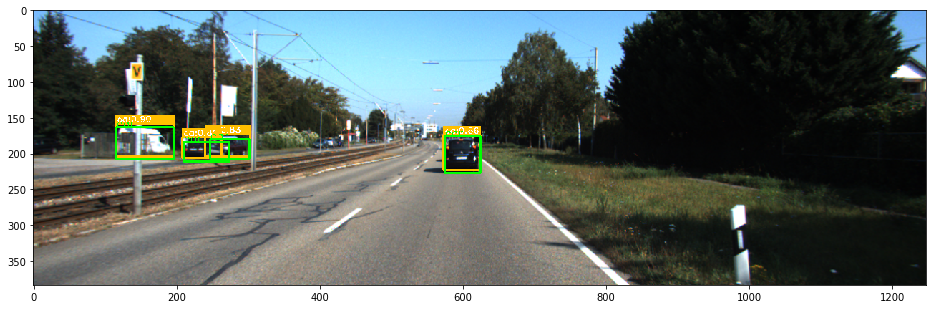

In [38]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 14
plt.rcParams["figure.figsize"] = fig_size
idx = 9
img = imgs[idx] / np.max(imgs[idx])
plt.imshow(img)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# imsave('predict ' + str(idx) + '.png', img)

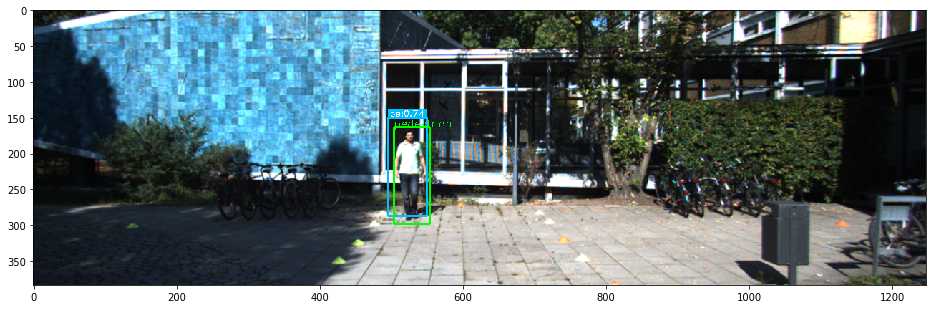

In [39]:
idx = 8
img = imgs[idx] / np.max(imgs[idx])
plt.imshow(img)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# imsave('predict ' + str(idx) + '.png', img)

**Failed to detect a car that is behind the first car**

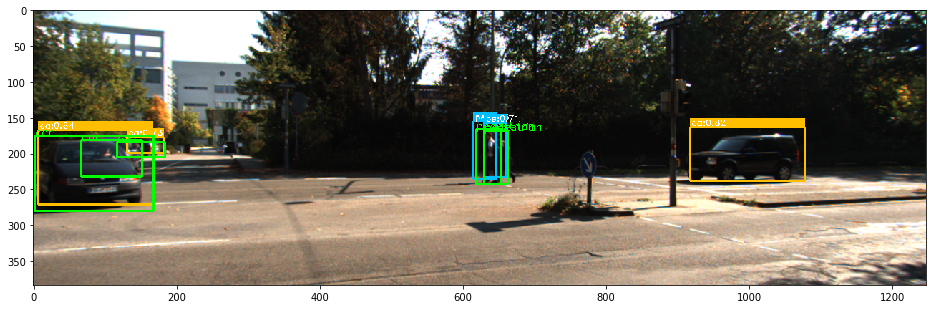

In [40]:
idx = 22
img = imgs[idx] / np.max(imgs[idx])
plt.imshow(img)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# imsave('predict ' + str(idx) + '.png', img)

## Generate Video & Patch Matching

In [0]:
# for Patch matching
pm_bboxes = []

def visualize_pr(model, generator):
    """
    Generates images with predicted bboxes.
    :param model: model of SqueezeDet
    :param generator: data generator that yields images and ground truth
    :returns: numpy array of images with prediction boxes
    """
    print("  Getting Visualizations, please wait...")
    res_imgs = []
    for i in range(len(generator)-1):
        images, orig_imgs = generator.__getitem__(i)
        y_pred = model.predict(images)
        # Create visualizations
        imgs_with_boxes = add_pr_boxes(orig_imgs, y_pred)
        try:
            res_imgs.append(np.stack(imgs_with_boxes))
        except:
            pass
    try:
        return np.stack(res_imgs).reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    except:
        return np.zeros((BATCH_SIZE*(len(generator)-1), IMAGE_HEIGHT, IMAGE_WIDTH, 3))


def add_pr_boxes(images, y_pred):
    """
    Takes a batch of images and creates bounding box visualization.
    """
    img_with_boxes = []
    filtered_boxes, filtered_classes, filtered_scores = filter_result(y_pred)

    for i, img in enumerate(images):
        pm_bboxes_per_image = []
        for j, det_box in enumerate(filtered_boxes[i]):
            # Transform into xmin, ymin, xmax, ymax format
            det_box = convert_bbox_diagonal(det_box)

            # Added the detected boudning box for patch matching 
            pm_bboxes_per_image.append(det_box)
            
            class_string = CLASS_NAMES[filtered_classes[i][j]]
            prob_string = "%.2f" % filtered_scores[i][j]
            # Draw bounding box and add text
            cv2.rectangle(img, (int(det_box[0]), int(det_box[3])), (int(det_box[2]), int(det_box[1])), CLASS_TO_COLOR[class_string], 2)
            if filtered_scores[i][j] is not None:
                # Write probability of detection on top line of the bbox:
                cv2.rectangle(img, (int(det_box[0]), int(det_box[1])), (int(det_box[2]), int(det_box[1]-12)),
                            CLASS_TO_COLOR[class_string], -1)
                cv2.putText(img, class_string[:2] + ":" + prob_string, (int(det_box[0])+2, int(det_box[1])-2), 2, 0.4,
                            (255,255,255), 0)
        pm_bboxes.append(pm_bboxes_per_image)
        img_with_boxes.append(img[:,:, [2,1,0]])
    return img_with_boxes

In [42]:
img_video_file = 'images_video.txt'
with open(img_video_file) as video_imgs:
    img_video_names = video_imgs.read().splitlines()
video_imgs.close()

vis_generator = DataGenVideo(img_video_names, batch_size=BATCH_SIZE, img_height=384, img_width=1248)
detect_imgs = visualize_pr(model=squeeze, generator=vis_generator)

  Getting Visualizations, please wait...


### Generate video Demo of detecting car and pedestrian

**Result Examples**

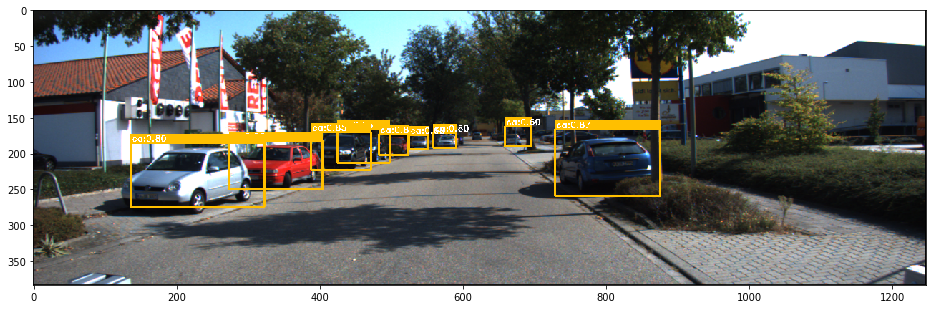

In [44]:
idx = 37
img = detect_imgs[idx] / np.max(detect_imgs[idx])
plt.imshow(img)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

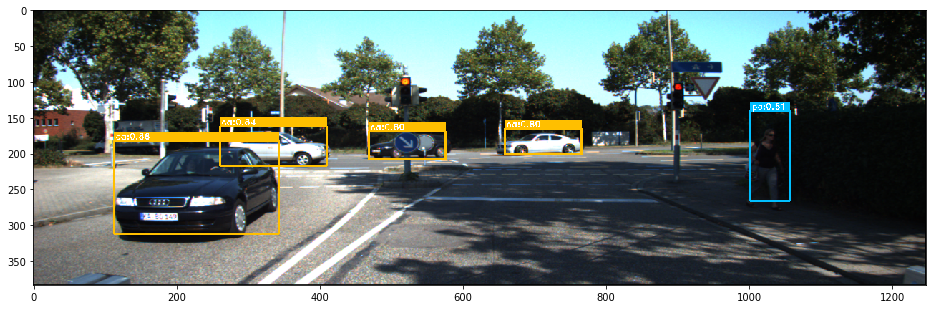

In [45]:
idx = 374
img = detect_imgs[idx] / np.max(detect_imgs[idx])
plt.imshow(img)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

**Failed example**

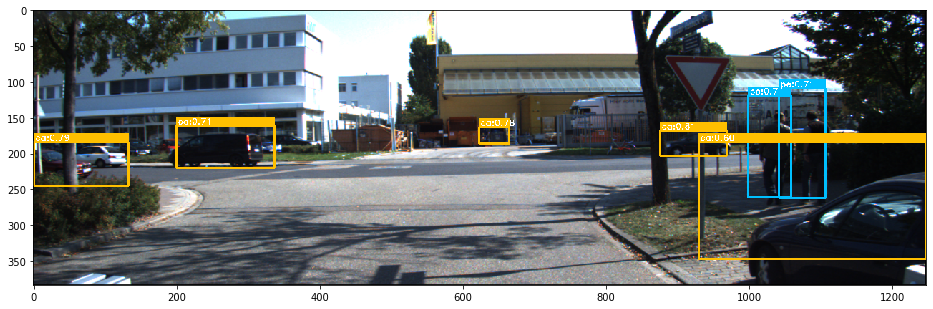

In [46]:
# Detect a trash can as a car
idx = 162
img = detect_imgs[idx] / np.max(detect_imgs[idx])
plt.imshow(img)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

In [0]:
results_dir = './video_img/'
# results_dir = './video_epoch110/'
# results_dir = './video_epoch140/'
for i in tqdm(range(len(detect_imgs))):
    img = detect_imgs[i] / np.max(detect_imgs[i])
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    pred_path = results_dir + '000000' + str(i) + '.png'
    imsave(pred_path, img)

In [0]:
height, width, layers = detect_imgs[0].shape
size = (width, height)
out = cv2.VideoWriter('project_video140.avi', cv2.VideoWriter_fourcc(*'MJPG'), 10, size)
for i in tqdm(range(len(detect_imgs))):
    image_path = results_dir + '000000' + str(i) + '.png'
    image = cv2.imread(image_path, -1)
    out.write(image)
out.release()

### Patch Matching

In [0]:
# Getting images for Patch matching
pm_images = []
for i in range((len(vis_generator)-1)*BATCH_SIZE):
    img = cv2.imread(img_video_names[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    pm_images.append(img)

In [0]:
# define helper functions
def add_semi_transparent_rect(img, box, color=(255,0,0), alpha=0.3):
    """
    params:
    img: input image
    box: coordinates of boundingbox in [xmin, ymin, xmax, ymax]
    color: tuple of 3 integers
    alpha: alpha value between 0 and 1
    returns image with semi transparent color added at box location
    """
    x1, y1, x2, y2 = np.round(box).astype('int')
    mask = img.copy()
    cv2.rectangle(mask, (x1, y1), (x2, y2), color, -1)
    cv2.addWeighted(mask, alpha, img, 1 - alpha, 0, img)
    # plt.imshow(img)
    return img

def get_patches(img, box):
    """
    params:
    img: input image
    box: coordinates of boundingbox in [xmin, ymin, xmax, ymax]
    returns all patches specified by boxes
    """
    res = []
    for i in range(len(box)):
        x1, y1, x2, y2 = np.round(box[i]).astype('int')
        res.append(img[y1:y2, x1:x2])
    return res

def sift_match(img1, img2, thres=0.6):
    """
    perform sift maching between two images. 
    returns keypoints from both images and matched keypoints
    """    
    sift = cv2.xfeatures2d.SIFT_create() #cv2.SIFT()
    bf = cv2.BFMatcher()

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    if len(kp1) <= 1 or len(kp2) <= 1:
        return kp1, kp2, []

    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < thres * n.distance:
            good.append([m])
    return kp1, kp2, good

In [0]:
 # constants
pm_results_dir = './patch_matching_img/'
score_thres = 0.01
num_colors = 20
colors = np.random.randint(0, 255, (num_colors, 3))
num_imgs = len(pm_bboxes)

In [50]:
all_colors = set(np.arange(num_colors))
all_pairs = []
pm_imgs_with_bboxes = []

# here, left image and right image basically means an adjacent pair of frames 
# r_patch: patches of right image. l_patches is for left images, similarly
# r_colors: colors assigned to patches in right image. l_colors is for left images, similarly
img2 = pm_images[0]
box2 = pm_bboxes[0]
r_patches = get_patches(img2, box2)
r_colors = [-1] * len(r_patches)

# iterate through all frames
for idx in tqdm(range(1, num_imgs)):
    # copy right image data to left image and load next right image (frame)
    img1 = img2.copy()
    img2 = pm_images[idx].copy()
    
    box1, box2 = pm_bboxes[idx-1:idx+1]

    # get all patches from both frames
    l_patches = r_patches.copy()
    r_patches = get_patches(img2, box2)

    # calculate scores of all possible matches. score = |matches| / (|kp1| + |kp2|)
    dice_scores = []
    l1 = len(l_patches)
    l2 = len(r_patches)

    # this is the data structure of dice_score. each array elements stores:
    # i1: the index of i1-th patch from left image
    # i2: the index of i2-th patch from left image
    # score: how good is the match between i1-th patch from first frame and i1-th patch from second frame
    for i1 in range(l1):
        l_p = l_patches[i1]
        for i2 in range(l2):
            r_p = r_patches[i2]
            kp1, kp2, good = sift_match(l_p, r_p)
            score = len(good) / (len(kp1) + len(kp2))
            dice_scores.append( [(i1, i2), score] )

    # sort scores
    dice_scores = sorted(dice_scores, key=lambda x: x[1], reverse=True)

    pairs = []
    used_color = set(r_colors)
    l_colors = r_colors.copy()
    r_colors = [-1] * l2

    num_scores = len(dice_scores)
    cnt = 0

    # recursively pick the best scores
    while num_scores > 0:
        cur_best = dice_scores[0]
        if cur_best[1] < score_thres:
            break
        
        # extract pair from stored score information
        good_pair = cur_best[0]
        l_idx, r_idx = good_pair
        pairs.append(good_pair)

        # align the colors assigned to the pair of matches
        if l_colors[l_idx] >= 0:
            r_colors[r_idx] = l_colors[l_idx]
        else:
            unused = list(all_colors - used_color)
            l_colors[l_idx] = unused[0]
            r_colors[r_idx] = unused[0]
            used_color.add(unused[0])
        
        # delete the pair from our score list, as they are already matched
        del dice_scores[0]
        num_scores -= 1

        # remove all scores associated with either matched patch
        # for example if we matched (3,5), then pairs like (3,4) or (1,5) should be dropped
        i = 0
        while i < num_scores:
            item = dice_scores[i]
            pair = item[0]
            if pair[0] == l_idx or pair[1] == r_idx:
                del dice_scores[i]
                num_scores -= 1
                i -= 1
            i += 1
    
    # add calculated color to all patches
    # if a patch does not have a color assigned, then pick one from unused colors
    unused = list(all_colors - used_color)
    for i in range(l1):
        color = l_colors[i]
        if color < 0:
            color = unused[0]
            l_colors[i] = color
            del unused[0]
            used_color.add(color)
        add_semi_transparent_rect(img1, box1[i], tuple(colors[color].tolist()))

    for i in range(l2):
        color = r_colors[i]
        if color < 0:
            color = unused[0]
            r_colors[i] = color
            del unused[0]
            used_color.add(color)
        add_semi_transparent_rect(img2, box2[i], tuple(colors[color].tolist()))

    # print(pairs)
    all_pairs.append(pairs)
    imsave(pm_results_dir + str(idx-1) + '.jpg', img1)
    pm_imgs_with_bboxes.append(img1)

imsave(pm_results_dir + str(idx) + '.jpg', img2)
pm_imgs_with_bboxes.append(img2)

**Result Examples**

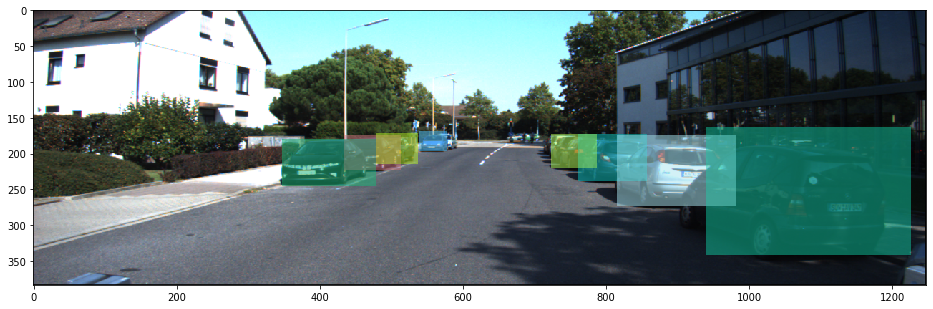

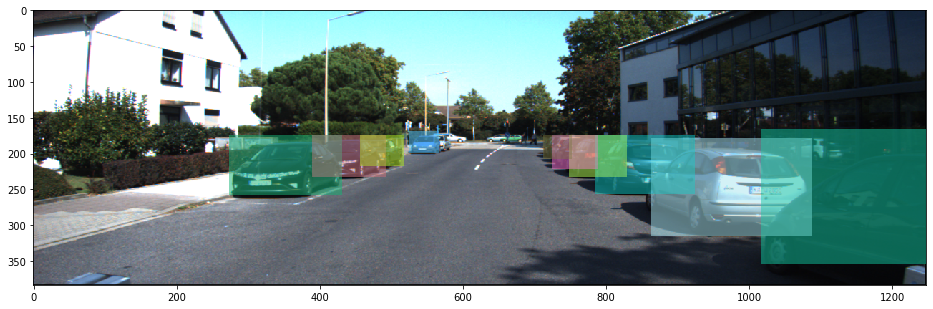

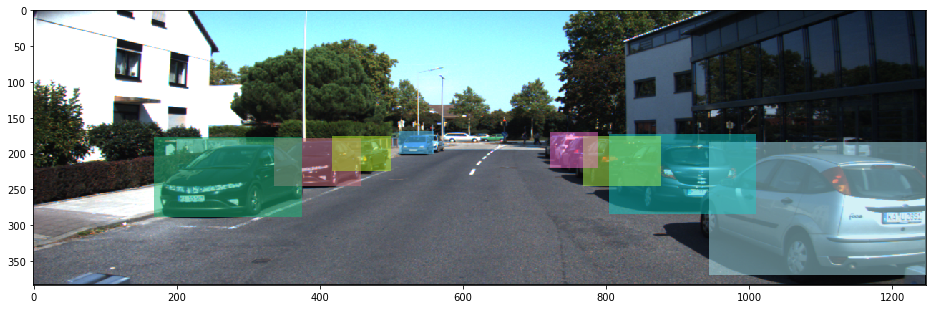

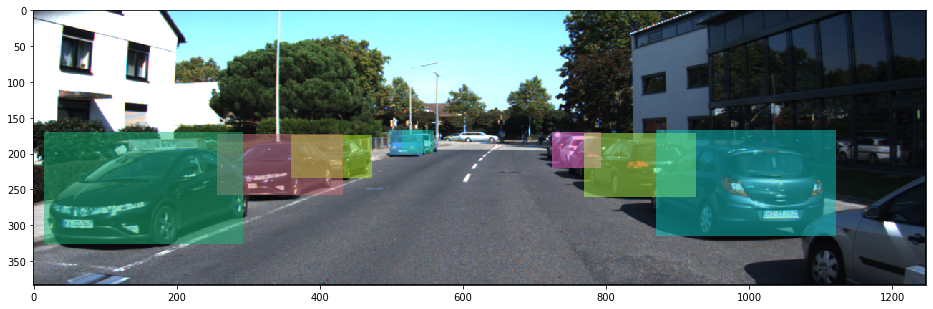

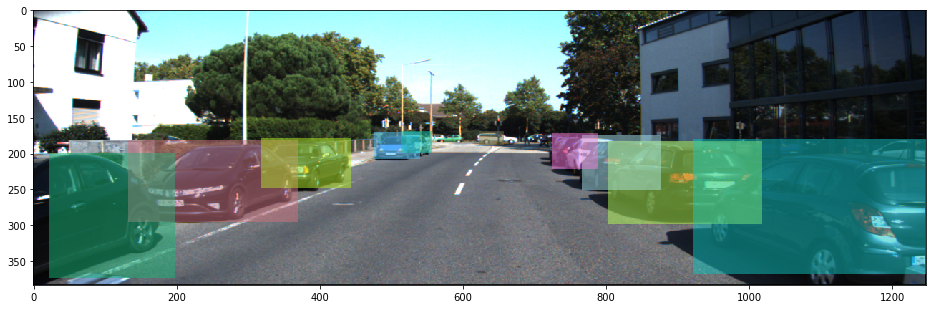

In [51]:
for idx in range(5):
    img = pm_imgs_with_bboxes[308 + idx*3]
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    plt.imshow(img)
    plt.show()

**Failed examples**

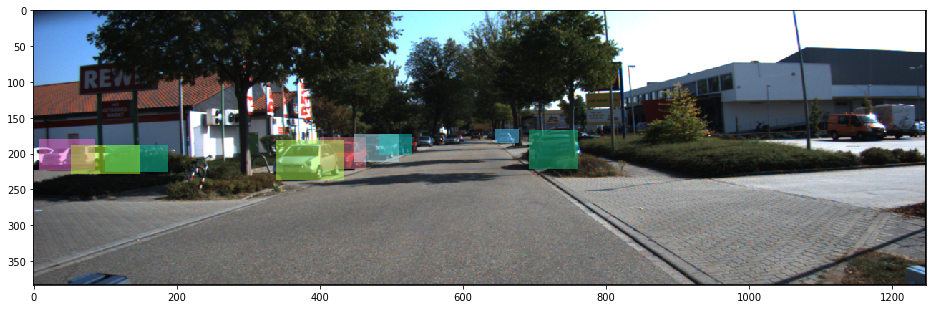

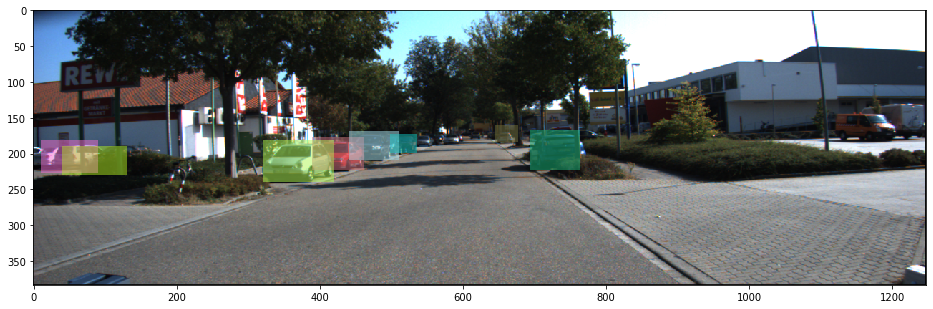

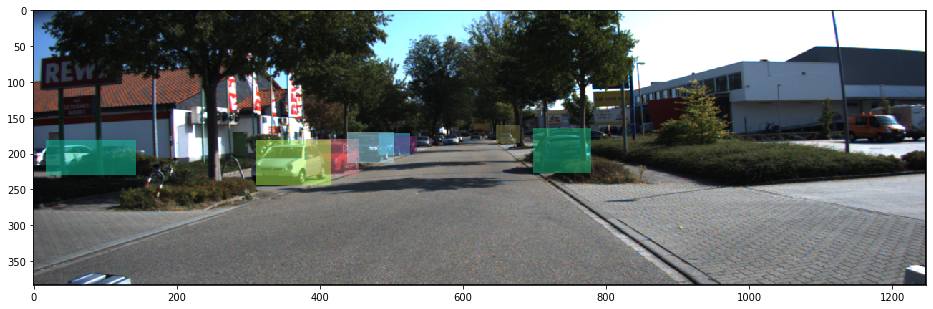

In [52]:
# One car failed to be matched
for idx in range(3):
    img = pm_imgs_with_bboxes[28 + idx]
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    plt.imshow(img)
    plt.show()

**Generate video Demo of patch matching**

In [0]:
height, width, layers = pm_imgs_with_bboxes[0].shape
size = (width, height)
out = cv2.VideoWriter('project_pm_video.avi', cv2.VideoWriter_fourcc(*'MJPG'), 10, size)
for i in tqdm(range(len(pm_imgs_with_bboxes))):
    image_path = pm_results_dir + str(i) + '.jpg'
    image = cv2.imread(image_path, -1)
    out.write(image)
out.release()